# Try MC-LSTM
The MC-LSTM is a modified LSTM with an inductive bias that conserves true mass states in its cell states (Hoedt, 2021)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *
from src.models.analyze_lstm_cell import *
from src.models import mclstm

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing
For MC-LSTM, mass inputs X_m (e.g. inflow) and auxillary inputs X_a (e.g. doy) need to be separated.

In [3]:
def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    X_train_a, X_val_a, X_test_a = ts_train[:, :, [3]], ts_val[:, :, [3]], ts_test[:, :, [3]] # auxillary input = doy
    X_train_m, X_val_m, X_test_m = ts_train[:, :, [0]], ts_val[:, :, [0]], ts_test[:, :, [0]] # mass input = inflow

    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train_m, X_train_a, y_train), (X_val_m, X_val_a, y_val), (X_test_m, X_test_a, y_test), pipeline.scaler
    else:
        return (X_train_m, X_train_a, y_train), (X_val_m, X_val_a, y_val), (X_test_m, X_test_a, y_test)

In [4]:
data_result = data_processing(name='Shasta', transform_type='standardize')

In [5]:
# Create PyTorch Dataset and Dataloader
dataset_train_res, dataset_val_res = (TensorDataset(*data_result[0]), 
                                      TensorDataset(*data_result[1]))
dataloader_train_res, dataloader_val_res = (DataLoader(dataset_train_res, batch_size=1, shuffle=False), 
                                            DataLoader(dataset_val_res, batch_size=1, shuffle=False))

## Load trained MC-LSTM

In [6]:
# Instantiate model and optimizer
torch.manual_seed(0)
mc_lstm = mclstm.MassConservingLSTM(in_dim=1, aux_dim=1, out_dim=1, batch_first=True)

In [7]:
mc_lstm.load_state_dict(torch.load('src/models/saved_models/mc_lstm_st.pt'))

<All keys matched successfully>

## Evaluate and plot results

In [8]:
def predict_mclstm(model, x_m, x_a):
    """
    Return predictions and cell states from a trained MC-LSTM model.
    Params:
    model -- trained PyTorch MC-LSTM model
    x_m -- input mass features
    x_a -- input auxillary features
    Returns:
    output -- model output on x
    """

    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        output, cell_states = model(x_m, x_a)
    
    return output, cell_states

In [9]:
def plot_and_eval_mclstm(model, train_data, val_data, test_data, datetime_index, ax, text_ypos, alpha=1):
    """ 
    Plot true and predicted labels for the entire dataset (train + val + test), as well as calculate and display R2 metrics for each
    Params:
    model -- PyTorch MCLSTM model of interest
    train_data/val_data/test_data -- Tuple, (X_m, X_a, y). Input data of shape (# batches, timesteps, # features), target data of shape (# batches, timesteps, 1)
    datetime_index -- datetime index for ENTIRE DATASET
    ax -- matplotlib axes to plot on
    text_ypos -- y coordinate to print r2 measure on plot
    alpha -- plotting transparency
    Returns:
    (r2_train, r2_val, r2_test) -- tuple of r2 metrics for the train, val, and test sets
    """
    # Get predictions
    y_hat_train, _ = predict_mclstm(model, train_data[0], train_data[1])
    y_hat_val, _ = predict_mclstm(model, val_data[0], val_data[1])
    y_hat_test, _ = predict_mclstm(model, test_data[0], test_data[1])

    # Flatten and remove padding values
    y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=train_data[2])
    y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=val_data[2])
    y_hat_test, y_test = flatten_rm_pad(y_hat=y_hat_test, y=test_data[2])

    # Get length of training/val/test datasets
    train_len, val_len, test_len = len(y_train), len(y_val), len(y_test)

    # Find R2 metrics
    r2_train = r2_score(y_pred=y_hat_train, y_true=y_train)
    r2_val = r2_score(y_pred=y_hat_val, y_true=y_val)
    r2_test = r2_score(y_pred=y_hat_test, y_true=y_test)
    metrics = (r2_train, r2_val, r2_test)

    # Concat results, check dimensions with datetime index
    y_hat, y = torch.cat((y_hat_train, y_hat_val, y_hat_test)), torch.cat((y_train, y_val, y_test))
    assert len(datetime_index) == len(y_hat) == len(y)

    # Plot
    ax.plot(datetime_index, y, label='observed', alpha=alpha)
    ax.plot(datetime_index, y_hat, label='predicted', alpha=alpha)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Scaled releases')
    ax.legend()
    # label training/val/test sets and their respective r2
    ax.axvline(x=datetime_index[train_len - 1], linestyle='--', color='black', alpha=alpha)
    ax.text(x=datetime_index[train_len], y=text_ypos, s=f'Training data: $R^2={round(r2_train, 2)}$ ', ha='right', va='top', size='large')

    ax.axvline(x=datetime_index[train_len + val_len - 1], linestyle='--', color='black', alpha=alpha)
    ax.text(x=datetime_index[train_len + val_len - 1], y=text_ypos, s=f'Validation data: $R^2={round(r2_val, 2)}$ ', ha='right', va='top', size='large')

    ax.axvline(x=datetime_index[train_len + val_len + test_len - 1], linestyle='--', color='black', alpha=alpha)
    ax.text(x=datetime_index[train_len + val_len + test_len - 1], y=text_ypos, s=f'Test data: $R^2={round(r2_test, 2)}$ ', ha='right', va='top', size='large')

    return metrics

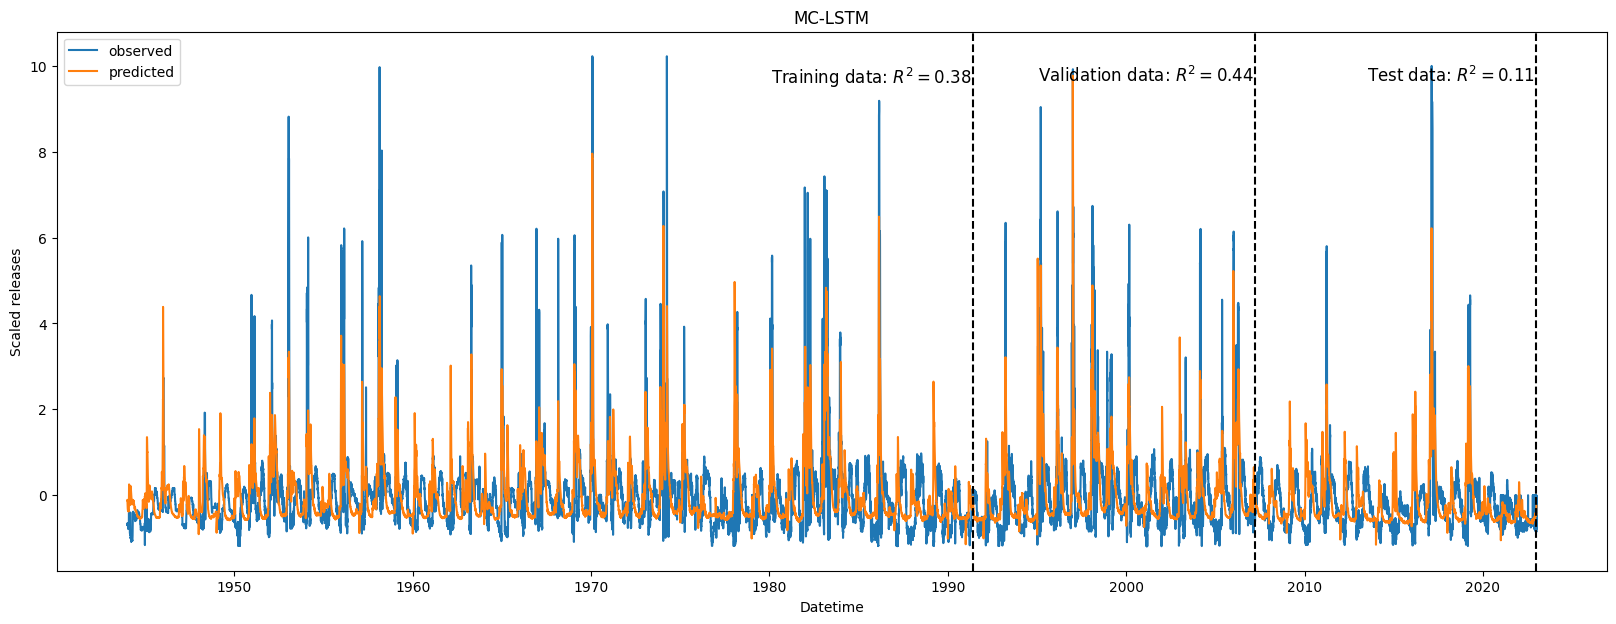

In [11]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval_mclstm(model=mc_lstm, train_data=data_result[0], val_data=data_result[1], test_data=data_result[2],
                     datetime_index=pd.date_range(start='1944-01-01', end='2022-12-31', freq='D'),
                     ax=ax, text_ypos=10)
plt.title('MC-LSTM')
plt.savefig('report/drafting/2_27_2024/figures/FigureS1_mclstm.png', dpi=300)
plt.show()

Surprisingly, the MC-LSTM performs very poorly overall, and the problem of false peaks still persists.

## Compare cell states with storage

In [16]:
# Get storage data
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

# check lengths of train/val/test sets
original_train_len = int(round(df.shape[0] * 0.6))
original_val_len = int(round(df.shape[0] * 0.2))
original_test_len = df.shape[0] - (original_train_len + original_val_len)

# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

storage_train.shape

(17313,)

In [15]:
# Get cell states, shape is (# chunks, timesteps, hidden size)
with torch.no_grad():
    cell_train = mc_lstm(data_result[0][0], data_result[0][1])[1]
    cell_val = mc_lstm(data_result[1][0], data_result[1][1])[1]
    cell_test = mc_lstm(data_result[2][0], data_result[2][1])[1]

cell_train.shape

torch.Size([16, 1095, 1])

### Correlation between storage and cell state

In [22]:
# Calculate correlations
correlation_data = {'Train':cell_correlations(cell_states=cell_train, storage_states=storage_train),
                    'Validation': cell_correlations(cell_states=cell_val, storage_states=storage_val),
                    'Test': cell_correlations(cell_states=cell_test, storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)
df_corr

,Train,Validation,Test
0,0.334606,0.46998,0.454712
